In [25]:
# ML Classifier: Predict Cell Types from RNA+ATAC

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
from imblearn.over_sampling import SMOTE


In [ ]:
# Load combined features and labels
X = np.load("results/files/X_combined.npy")
y = np.load("results/files/y_labels.npy", allow_pickle=True)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate performance
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
# Some warning from the evaluation showed that some cell types in the test set were not predicted at all by the model 
# To inspect how many samples per class are in training and testing
import pandas as pd

train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

print("Training set distribution:")
print(train_counts)

print("\nTest set distribution:")
print(test_counts)


In [28]:
# Output showed

# | Label | Approx. Cell Type       | Train Count | Test Count |
# | ----- | ----------------------- | ----------- | ---------- |
# | 8     | Mito-rich/Unknown       | 1260        | 315        |
# | 5     | B cells                 | 612         | 153        |
# | 1     | Monocytes               | 438         | 109        |
# | 3     | Memory T cells          | 228         | 57         |
# | 2     | Cytotoxic T/NK          | 194         | 48         |
# | 0     | Naive T cells           | 174         | 44         |
# | 6     | Monocytes / Neutrophils | 134         | 34         |
# | 7     | NK cells                | 127         | 32         |
# | 4     | Dendritic cells         | 18          |   4        |
# | 9     | pDCs or DC subtype      | 15          |   4        |

# Classes 4 and 9 are severely underrepresented were never predicted these at all, causing precision = 0
# Classes like 8, 5, and 1 dominates and the model is likely biased toward them



In [ ]:
# Apply SMOTE to training data to balance class distributions in training data by generating synthetic examples for underrepresented classes
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())  # Should now be balanced

# Result
#1    1260
#8    1260
#2    1260
#5    1260
#0    1260
#6    1260
#7    1260
#9    1260
#3    1260
#4    1260

In [ ]:

# Then train on SMOTE-resampled data and use class balancing via class_weight='balanced' to weigh rare classes more
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_resampled, y_resampled)

# Predict on original test set
y_pred = clf.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [9]:
# Still same result, class 4 and 9 still poorly predicted 
# Try combining SMOTE with Tomek links (clean noisy synthetic samples)
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)


In [ ]:
# Then train again
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_resampled, y_resampled)

# Predict on original test set
y_pred = clf.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# No changes, class 4 and 9 still poorly predicted 
# Try different ML model
# Try trainning an XGBoost classifier on SMOTE-resampled data
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
)

# Fit on SMOTE-resampled training data
xgb_clf.fit(X_resampled, y_resampled)

# Predict on original test set
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Save model
joblib.dump(xgb_clf, "results/files/xgb_model.pkl")

In [ ]:
# No changes, class 4 and 9 still poorly predicted 
# Try different ML model
# Try trainning an XGBoost classifier on SMOTE-resampled data
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
)

# Fit on SMOTE-resampled training data
xgb_clf.fit(X_resampled, y_resampled)

# Predict on original test set
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Save classification report
report = classification_report(y_test, y_pred_xgb, output_dict=True)
pd.DataFrame(report).transpose().to_csv('results/files/xgb_classification_report.csv')


# Save model
joblib.dump(xgb_clf, "results/files/xgb_model.pkl")

In [ ]:
# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Cell Type Classification Confusion Matrix")
plt.tight_layout()
plt.savefig("results/plots/confusion_matrix.png")
plt.show()

In [ ]:

# optional: tune XGBoost hyperparameters to boost performance, optimize model settings using cross-validation and return the best configuration.
# Then use best configuration in training test data
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Define base model
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=10,
    eval_metric='mlogloss',
    use_label_encoder=False,
    verbosity=1
)

# Define a reduced hyperparameter space
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

# Randomized search: try 20 random combinations, use 3-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


# Fit on the resampled training set
random_search.fit(X_resampled, y_resampled)

# Best model and performance
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)



In [ ]:
# Then evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Visualize  Class Probability Distributions
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predicted probabilities
y_proba = best_model.predict_proba(X_test)

# Plot for a few example classes
for i in [0, 1, 2, 5, 8]:
    sns.histplot(y_proba[:, i], bins=25, kde=True, label=f'Class {i}', alpha=0.6)

plt.title("Predicted Class Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("results/plots/Probability_distributions2.png")
plt.show()

In [37]:
#Save the Model and Results
joblib.dump(best_model, 'results/files/xgb_best_model.pkl')

# Save classification report
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose().to_csv('results/files/xgb_classification_report.csv')


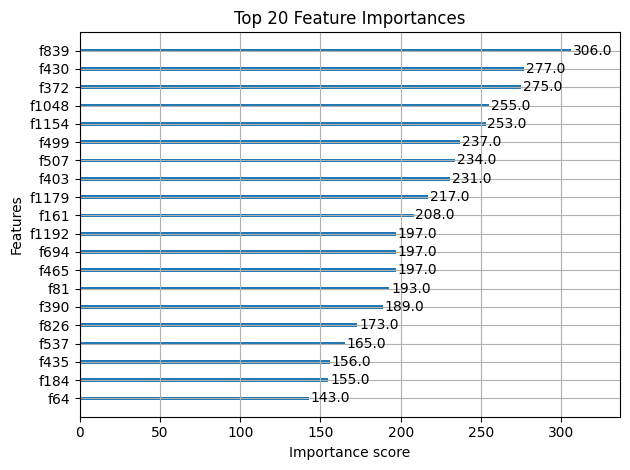

In [39]:
# Feature Importance Analysis
from xgboost import plot_importance

plot_importance(best_model.best_estimator_, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.savefig('results/plots/xgb_feature_importance.png')
plt.show()


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import joblib
import os
from sklearn.metrics import accuracy_score


# Load the combined data with feature names and labels
df = pd.read_csv("results/files/X_combined_with_labels.csv")
X = df.drop(columns=['cell_type'])
y = df['cell_type']

# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Save the label encoder for inverse transform later
joblib.dump(le, "results/files/label_encoder.pkl")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [ ]:
# Define the XGBoost model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Define a reduced hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

# Retrain best model using StratifiedKFold
best_model = random_search.best_estimator_
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

accuracies = []
for train_idx, val_idx in skf.split(X_train, y_train):
    best_model.fit(X_train.iloc[train_idx], y_train[train_idx])
    acc = best_model.score(X_train.iloc[val_idx], y_train[val_idx])
    accuracies.append(acc)

print(f"Mean CV Accuracy after retraining: {np.mean(accuracies):.4f}")


In [59]:

# Final evaluation on test set
y_pred = best_model.predict(X_test)
pred_labels = le.inverse_transform(y_pred)
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Save model
joblib.dump(best_model, "results/files/xgb_best_model.pkl")
# Save raw prediction (numerical)
np.save("results/files/y_pred.npy", y_pred)
# Save true test labels if needed
np.save("results/files/y_test.npy", y_test)
# Predict on full dataset for UMAP visualization
full_preds = best_model.predict(X)
np.save("results/files/y_pred_full.npy", full_preds)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Test Set Classification Report:
                         precision    recall  f1-score   support

                B cells       0.98      1.00      0.99        44
         Cytotoxic T/NK       0.89      0.90      0.89       109
        Dendritic cells       1.00      0.94      0.97        48
         Memory T cells       0.94      0.84      0.89        57
      Mito-rich/Unknown       1.00      0.75      0.86         4
              Monocytes       0.93      0.98      0.96       153
Monocytes / Neutrophils       0.84      0.62      0.71        34
               NK cells       0.86      1.00      0.93        32
          Naive T cells       0.95      0.97      0.96       315
     pDCs or DC subtype       1.00      1.00      1.00         4

               accuracy                           0.94       800
              macro avg       0.94      0.90      0.92       800
           weighted avg       0.94      0.94      0.93       800

Test Accuracy: 0.9363


<Figure size 1000x800 with 0 Axes>

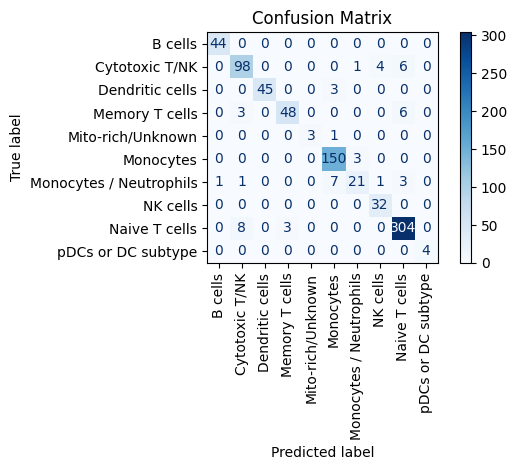

In [49]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("results/plots/confusion_matrix.png")
plt.show()


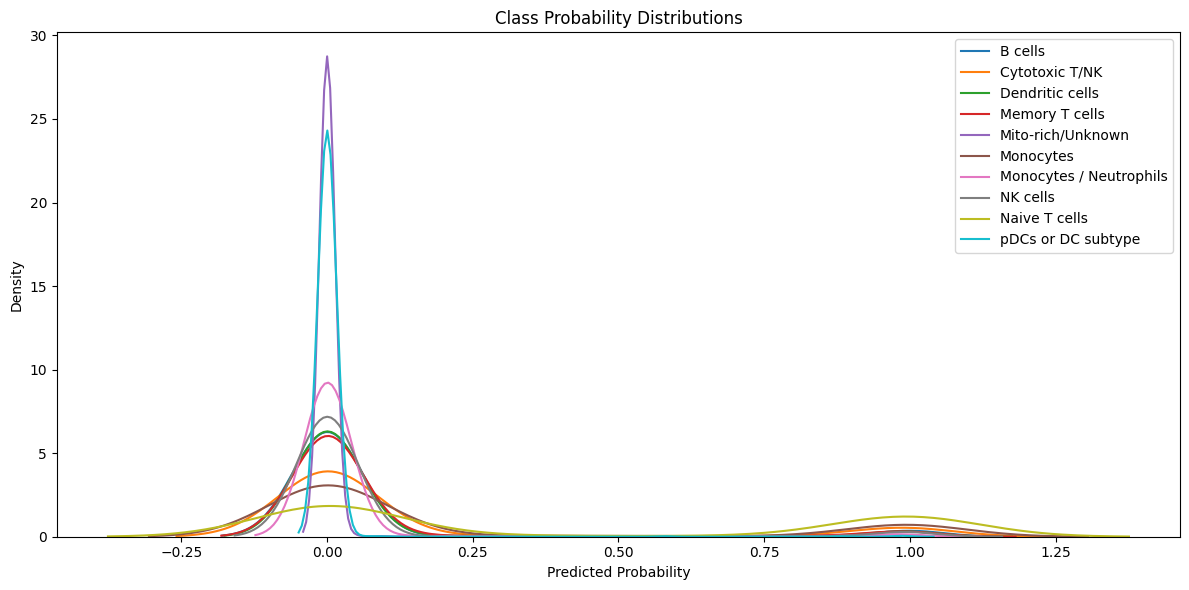

In [50]:
# Class Probability Distribution
y_proba = best_model.predict_proba(X_test)

plt.figure(figsize=(12, 6))
for i in range(len(le.classes_)):
    sns.kdeplot(y_proba[:, i], label=le.classes_[i])

plt.title("Class Probability Distributions")
plt.xlabel("Predicted Probability")
plt.legend()
plt.tight_layout()
plt.savefig("results/plots/class_probability_distribution.png")
plt.show()

In [51]:
# Feature Importance
importances = best_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.to_csv("results/files/feature_importance.csv", index=False)



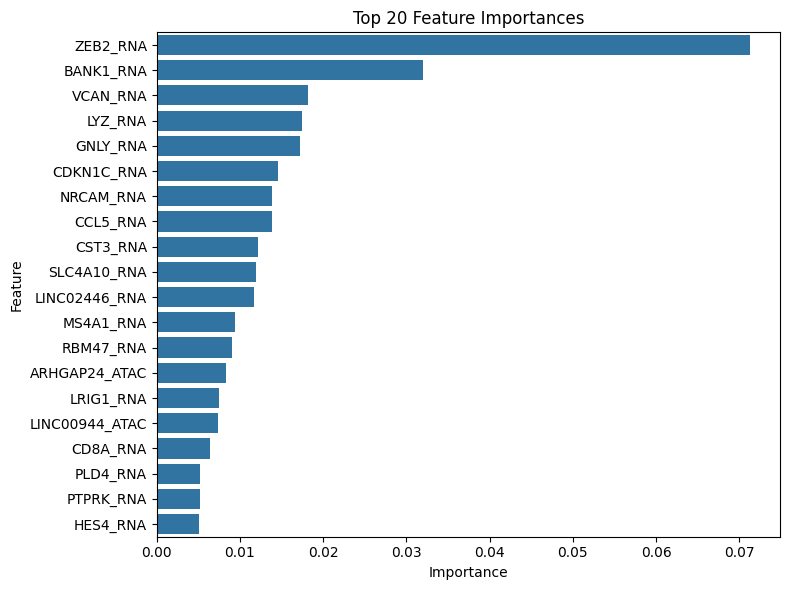

In [52]:
# Plot top 20
top_n = 20
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
plt.title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.savefig("results/plots/feature_importance_top20.png")
plt.show()
